In [1]:
import os
import sys
import logging
import argparse

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from PIL import Image
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import torch

from torchvision import transforms
from detectron2.data import MetadataCatalog
from detectron2.utils.colormap import random_color
from xdecoder.BaseModel import BaseModel
from xdecoder import build_model
from utils.visualizer import Visualizer
from utils.distributed import init_distributed

import warnings
warnings.filterwarnings(action='ignore')
logger = logging.getLogger(__name__)

from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt

/home/djjin/Mygit/X-Decoder


/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
parser = argparse.ArgumentParser(description='Pretrain or fine-tune models for NLP tasks.')
parser.add_argument('--command', default="evaluate", help='Command: train/evaluate/train-and-evaluate')
parser.add_argument('--conf_files', nargs='+', help='Path(s) to the config file(s).')
parser.add_argument('--user_dir', help='Path to the user defined module for tasks (models, criteria), optimizers, and lr schedulers.')
parser.add_argument('--config_overrides', nargs='*', help='Override parameters on config with a json style string, e.g. {"<PARAM_NAME_1>": <PARAM_VALUE_1>, "<PARAM_GROUP_2>.<PARAM_SUBGROUP_2>.<PARAM_2>": <PARAM_VALUE_2>}. A key with "." updates the object in the corresponding nested dict. Remember to escape " in command line.')
parser.add_argument('--overrides', help='arguments that used to override the config file in cmdline', nargs=argparse.REMAINDER)

cmdline_args = parser.parse_args('')

In [3]:
cmdline_args.conf_files = [os.path.join(home_dir, "configs/xdecoder/segvlp_focalt_lang.yaml")]
cmdline_args.overrides = ['WEIGHT', 'true', 'RESUME_FROM', '../checkpoints/xdecoder_focalt_best_openseg.pt'] 
cmdline_args.overrides

['WEIGHT',
 'true',
 'RESUME_FROM',
 '../checkpoints/xdecoder_focalt_best_openseg.pt']

In [4]:
opt = load_opt_from_config_files(cmdline_args.conf_files)

keys = [cmdline_args.overrides[idx*2] for idx in range(len(cmdline_args.overrides)//2)]
vals = [cmdline_args.overrides[idx*2+1] for idx in range(len(cmdline_args.overrides)//2)]
vals = [val.replace('false', '').replace('False','') if len(val.replace(' ', '')) == 5 else val for val in vals]
types = []
for key in keys:
    key = key.split('.')
    ele = opt.copy()
    while len(key) > 0:
        ele = ele[key.pop(0)]
    types.append(type(ele))

config_dict = {x:z(y) for x,y,z in zip(keys, vals, types)}
config_dict

load_config_dict_to_opt(opt, config_dict)
for key, val in cmdline_args.__dict__.items():
    if val is not None:
        opt[key] = val

In [5]:
opt = init_distributed(opt)

In [6]:
pretrained_pth = os.path.join(opt['RESUME_FROM'])
output_root = './output'
image_pth = '../images/animals.png'
print(pretrained_pth)

../checkpoints/xdecoder_focalt_best_openseg.pt


In [7]:
model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()

*UNLOADED* sem_seg_head.predictor.pos_embed_caping.weight, Model Shape: torch.Size([77, 512])
$UNUSED$ sem_seg_head.predictor.query_feat_caping.weight, Ckpt Shape: torch.Size([77, 512])


In [8]:
t = []
t.append(transforms.Resize(512, interpolation=Image.BICUBIC))
transform = transforms.Compose(t)
transform

Compose(
    Resize(size=512, interpolation=bicubic, max_size=None, antialias=None)
)

In [9]:
stuff_classes = ['zebra','antelope','giraffe','ostrich','sky','water','grass','sand','tree']
stuff_colors = [random_color(rgb=True, maximum=255).astype(np.int).tolist() for _ in range(len(stuff_classes))]
stuff_dataset_id_to_contiguous_id = {x:x for x in range(len(stuff_classes))}

In [10]:
MetadataCatalog.get("demo").set(
    stuff_colors=stuff_colors,
    stuff_classes=stuff_classes,
    stuff_dataset_id_to_contiguous_id=stuff_dataset_id_to_contiguous_id,
)
model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(stuff_classes + ["background"], is_eval=True)
metadata = MetadataCatalog.get('demo')
model.model.metadata = metadata
model.model.sem_seg_head.num_classes = len(stuff_classes)

(970, 1602, 3)


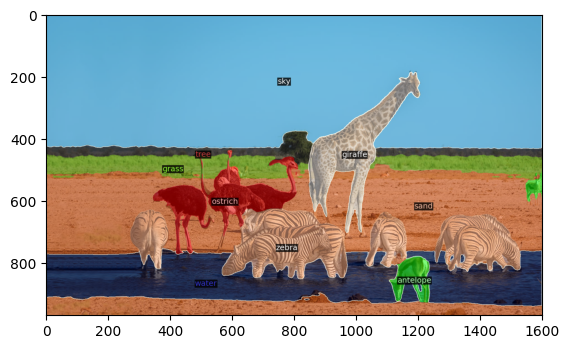

In [11]:
from matplotlib import pyplot as plt
with torch.no_grad():
    image_ori = Image.open(image_pth).convert("RGB")
    width = image_ori.size[0]
    height = image_ori.size[1]
    image = transform(image_ori)
    image = np.asarray(image)
    image_ori = np.asarray(image_ori)
    images = torch.from_numpy(image.copy()).permute(2,0,1).cuda()

    batch_inputs = [{'image': images, 'height': height, 'width': width}]
    outputs = model.forward(batch_inputs)
    visual = Visualizer(image_ori, metadata=metadata)

    sem_seg = outputs[-1]['sem_seg'].max(0)[1]
    demo = visual.draw_sem_seg(sem_seg.cpu(), alpha=0.5) # rgb Image

    # if not os.path.exists(output_root):
    #     os.makedirs(output_root)
    # demo.save(os.path.join(output_root, 'sem.png'))

    image = demo.get_image()
    print(image.shape)
    plt.imshow(image)
    plt.show()